# Scraping data from "FiveThirtyEight"

FiveThirtyEight is by far my favorite site. I read just about all of their content in politics, sports, culture, econ, etc. One of the best things about FiveThirtyEigth is that they post a ton of their data, specifically on GitHub (https://github.com/fivethirtyeight/data). In this notebook, instead of pulling data from their GitHub repository, I'm going to scrape it from the underlying HTML code. 

If you're a follower of FiveThirtyEight, you've probably seen this VIZ before. It's always on the side bar of their homepage.


![538 DJT Approval Meter](https://cse6040.gatech.edu/datasets/538-djt-pop/538-demo.png)


# Defining the Task

The visual journalists at FiveThirtyEight do a remarkable job. I rarely find a VIZ of theirs that I don't love. For this exercise, I'm going to scrape the data behind the VIZ above, and put it into a readily useful format in pandas (and maybe do some VIZ work at the end).


# Downloading and Extracting the HTML

The raw contents of the HTML have been put into a PDF- which I'll then store in a variable - `raw_html`. The included has a most recent date of September 6th, 2018 for the approval rating.


In [1]:
def download(url, local_file, overwrite=False):
    import os, requests
    if not os.path.exists(local_file) or overwrite:
        print("Downloading: {} ...".format(url))
        r = requests.get(url)
        with open(local_file, 'wb') as f:
            f.write(r.content)
        return True
    return False # File existed already

def get_checksum(local_file):
    import io, hashlib
    with io.open(local_file, 'rb') as f:
        body = f.read()
        body_checksum = hashlib.md5(body).hexdigest()
        return body_checksum

def download_or_load_locally(file, local_dir="", url_base=None, checksum=None):
    if url_base is None: url_base = "https://cse6040.gatech.edu/datasets/"
    local_file = "{}{}".format(local_dir, file)
    remote_url = "{}{}".format(url_base, file)
    download(remote_url, local_file)
    if checksum is not None:
        body_checksum = get_checksum(local_file)
        assert body_checksum == checksum, \
            "Downloaded file '{}' has incorrect checksum: '{}' instead of '{}'".format(local_file,
                                                                                       body_checksum,
                                                                                       checksum)        
    print("'{}' is ready!".format(file))
    
def on_vocareum():
    import os
    return os.path.exists('.voc')

if on_vocareum():
    URL_BASE = None
    DATA_PATH = "../resource/asnlib/publicdata/538-djt-pop/"
else:
    URL_BASE = "https://cse6040.gatech.edu/datasets/538-djt-pop/"
    DATA_PATH = ""
datasets = {'2018-09-06.html': '291a7c1cbf15575a48b0be8d77b7a1d6'}

for filename, checksum in datasets.items():
    download_or_load_locally(filename, url_base=URL_BASE, local_dir=DATA_PATH, checksum=checksum)

with open('{}{}'.format(DATA_PATH, '2018-09-06.html')) as fp:
    raw_html = fp.read()
print("\n(All data appears to be ready.)")

'2018-09-06.html' is ready!

(All data appears to be ready.)


**File snippets.** I don't need all of the data in the PDF, so I'm only going to extract what I need - which starts at page 50

In [2]:
sample_offset, sample_len = 69950, 1500
print(raw_html[sample_offset:sample_offset+sample_len])

Page = {};
interactivePage.navSlug = 'approval';
var pathPrefix="/trump-approval-ratings/";
var subgroup="All polls";
var showMoreCutoff=5;
var approval=[{"date":"2017-01-23","future":false,"subgroup":"All polls","approve_estimate":"45.46693","approve_hi":"50.88971","approve_lo":"40.04416","disapprove_estimate":"41.26452","disapprove_hi":"46.68729","disapprove_lo":"35.84175"},{"date":"2017-01-24","future":false,"subgroup":"All polls","approve_estimate":"45.44264","approve_hi":"50.82922","approve_lo":"40.05606","disapprove_estimate":"41.87849","disapprove_hi":"47.26508","disapprove_lo":"36.49191"},{"date":"2017-01-25","future":false,"subgroup":"All polls","approve_estimate":"47.76497","approve_hi":"52.66397","approve_lo":"42.86596","disapprove_estimate":"42.52911","disapprove_hi":"47.42811","disapprove_lo":"37.63011"},{"date":"2017-01-26","future":false,"subgroup":"All polls","approve_estimate":"44.37598","approve_hi":"48.93261","approve_lo":"39.81936","disapprove_estimate":"41.06081","

Here is a sample of the end of the raw data:

In [3]:
sample_end = 257500
print(raw_html[sample_end:sample_end+sample_len])

s","approve_estimate":"41.46994","approve_hi":"53.69857","approve_lo":"29.24131","disapprove_estimate":"51.94407","disapprove_hi":"63.94288","disapprove_lo":"39.94526"},{"date":"2019-05-10","future":true,"subgroup":"All polls","approve_estimate":"41.47093","approve_hi":"53.72246","approve_lo":"29.2194","disapprove_estimate":"51.94225","disapprove_hi":"63.96438","disapprove_lo":"39.92012"},{"date":"2019-05-11","future":true,"subgroup":"All polls","approve_estimate":"41.4719","approve_hi":"53.74633","approve_lo":"29.19748","disapprove_estimate":"51.94044","disapprove_hi":"63.98589","disapprove_lo":"39.895"},{"date":"2019-05-12","future":true,"subgroup":"All polls","approve_estimate":"41.47285","approve_hi":"53.77016","approve_lo":"29.17555","disapprove_estimate":"51.93866","disapprove_hi":"64.0074","disapprove_lo":"39.86993"},{"date":"2019-05-13","future":true,"subgroup":"All polls","approve_estimate":"41.47378","approve_hi":"53.79396","approve_lo":"29.15361","disapprove_estimate":"51.93

**Observations about the file snippets shown above:**

- Each "data point" or "data record" is encoded in JavaScript Object Notation (JSON), which is essentially the same as a Python dictionary. Enclosed in the curly brackets are key-value pairs. These include the date (`"date":"yyyy-mm-dd"`), approval and disapproval rating estimates (`"approve_estimate":"45.46693"` and `"disapprove_estimate":"41.26452"`), as well as upper and lower error bounds (`"..._hi"` and `"..._lo"`). The estimates correspond to the green (approval) and orange (disapproval) lines, and the error bounds form the shaded regions around those lines.
- Each data record includes a key named `"future"`. That's because FiveThirtyEight has projected the ratings into the future, so some records correspond to observed values (`"future":false`) while others correspond to extrapolated values (`"future":true`).


These obsrvations will help when it comes to recognizing and extracting patterns in the data.



## Extracting the meaningful data elements

**First Task: Extracting relevant data** The data I need begins with `'var approval=[...'` and ends with a closing square bracket, `']'`. This is the only such occurance of this pattern in the raw data. I'm going to use regular expressions to find the pattern I'm looking for.

In [4]:
import re

def extract_approval_raw(html):
    pattern = re.compile(r'\[(.*)\]')
    matches = pattern.findall(html)
    str_version = matches[0]
    return str_version
    
    
raw_data = extract_approval_raw(raw_html)

print("=== First and last 300 characters ===\n{}\n   ...   \n{}".format(raw_data[:300], raw_data[-300:]))

=== First and last 300 characters ===
{"date":"2017-01-23","future":false,"subgroup":"All polls","approve_estimate":"45.46693","approve_hi":"50.88971","approve_lo":"40.04416","disapprove_estimate":"41.26452","disapprove_hi":"46.68729","disapprove_lo":"35.84175"},{"date":"2017-01-24","future":false,"subgroup":"All polls","approve_estimat
   ...   
e_estimate":"51.9369","disapprove_hi":"64.02892","disapprove_lo":"39.84487"},{"date":"2019-05-14","future":true,"subgroup":"All polls","approve_estimate":"41.47469","approve_hi":"53.81773","approve_lo":"29.13165","disapprove_estimate":"51.93515","disapprove_hi":"64.05045","disapprove_lo":"39.81984"}


**Finding the Approval Ratings** Now I'll create a function, `extract_approval_estimates(data_substr)`,which will takes as input a string, `data_substr`, which would be a data substring like the one returned by `extract_approval_raw()`. It will return a **dictionary** where

- each key is a date, stored as a string in the form `'2017-01-23'` (**without the quotes**);
- each corresponding value is the approval rating, **stored as a `float`**.

For example, executing

```python
    approvals = extract_approval_estimates(data_substr)
    print(type(approvals['2017-01-23']), approvals['2017-01-23'])
```
 `<class 'float'> 45.46693`

I'm **only** going to keep records for which `"future":false`- and not worry about the projected values (Although, it would be  a cool exercise to compare projected vs actual).


In [5]:
from collections import defaultdict

def extract_approval_estimates(data_substr):
    date = re.compile(r'\"(\d{4}\-\d{2}\-\d{2})\",\"future\":false')
    approval = re.compile(r'\"approve_estimate\":\"(\d{2}\.\d+)')
    
    date_matches = date.findall(data_substr)
    approval_matches = approval.findall(data_substr)
    approval_matches = [float(match) for match in approval_matches]
    
    result = defaultdict(float)
    for d,a in zip(date_matches,approval_matches):
        result[d] = a
    
    return dict(result)
    
    
approvals = extract_approval_estimates(raw_data)
#approvals
print("Found {} data records.".format(len(approvals)))

Found 592 data records.


**Same as above- now for Disapproval Ratings:**

For instance, executing

```python
disapprovals = extract_disapproval_estimates(raw_data)
print(type(disapprovals['2017-01-23']), disapprovals['2017-01-23'])
```

should display, `<class 'float'> 41.26452`.

In [6]:
def extract_disapproval_estimates(data_substr):

    date = re.compile(r'\"(\d{4}\-\d{2}\-\d{2})\",\"future\":false')
    approval = re.compile(r'\"disapprove_estimate\":\"(\d{2}\.\d+)')
    
    date_matches = date.findall(data_substr)
    approval_matches = approval.findall(data_substr)
    approval_matches = [float(match) for match in approval_matches]
    
    result = defaultdict(float)
    for d,a in zip(date_matches,approval_matches):
        result[d] = a
    
    return dict(result)

disapprovals = extract_disapproval_estimates(raw_data)
print("Found {} data records.".format(len(disapprovals)))

Found 592 data records.


## Creating Pandas DataFrames

Now that I have the approvals and disapprovals, I can create a pandas dataframe, which then can be used for analysis. 

In [7]:
import pandas as pd

#Creating separate dfs for approvals and disapprovals
df = pd.DataFrame(list(approvals.items()),columns = ['Date','Approval Rating'])
df2 = pd.DataFrame(list(disapprovals.items()),columns = ['Date','Disapproval Rating'])

#Joining the dataframes and converting the 'Date' columns to dtype = datetime
df3 = df.merge(df2, on = 'Date',how = 'left')
df3['Date'] = pd.to_datetime(df3['Date'])

#Inspect the top 10 rows of the dataframe
df3.head(10)


,Date,Approval Rating,Disapproval Rating
0,2017-01-23,45.46693,41.26452
1,2017-01-24,45.44264,41.87849
2,2017-01-25,47.76497,42.52911
3,2017-01-26,44.37598,41.06081
4,2017-01-27,44.13586,41.67268
5,2017-01-28,43.87527,41.91362
6,2017-01-29,44.14589,42.22470
7,2017-01-30,44.09903,42.45613
8,2017-01-31,44.34048,43.45351
9,2017-02-01,44.79341,44.69287


## Visualizing the Data

Now that I have some useful data, I can start to vizualize it. I won't be able to create a VIZ identical to the top picture, but I can at least show the trend in the data. To do this, I'm going to use the python library bokeh.

In [8]:
from IPython.display import display, Markdown
import bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.io import show
from bokeh.models import HoverTool
output_notebook ()

Loading BokehJS ...

In [9]:
p = figure(title="Trump Approval Rating",x_axis_type="datetime",plot_width=600, plot_height=400,
          y_range = (20,70))

p.grid.grid_line_alpha=0.3
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Rating'
p.line(x=df3['Date'], y=df3['Approval Rating'],
      line_color = 'Green',line_width = 3, legend = 'Approval Rating')
p.line(x=df3['Date'], y=df3['Disapproval Rating'],
      line_color = 'lightcoral', line_width = 3,legend = 'Diapproval Rating')
p.legend.location = "bottom_left"

show(p)

Image of graph below for GitHub

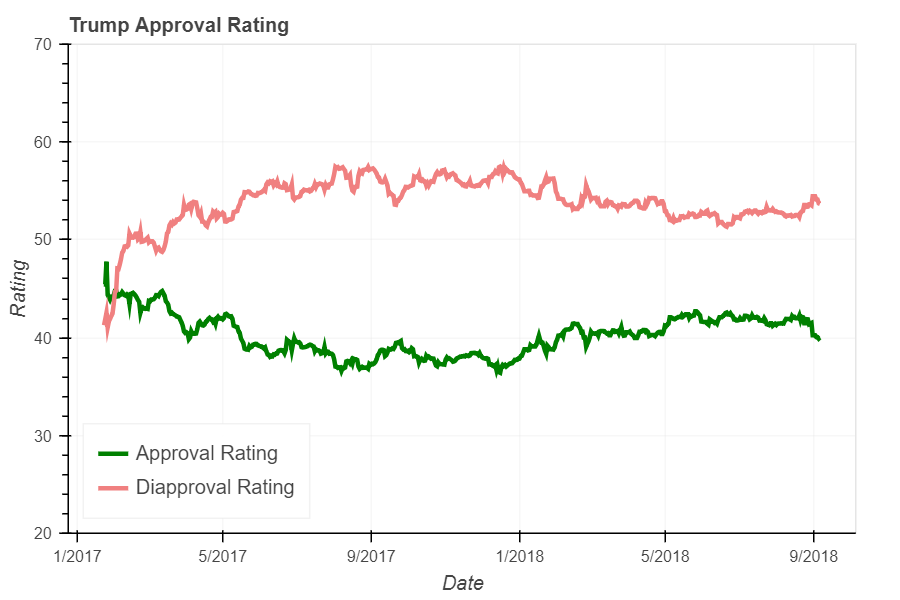

In [13]:
from IPython.display import Image
PATH = "C:/Users/Spelk/Desktop/Georgia Tech Analytics/CSE 6040/Midterm 1- Actual/"
Image(filename = PATH + "bokeh_plot.png", width=600, height=400)

That's it for now - my preffered visual tool is Tableau - which I am much more familiar with. In there I could creat a VIZ much more similar to the original one.